In [1]:
import os.path as osp
import os
import torch
import torch.nn.functional as F
%matplotlib inline
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, GNNExplainer
from torch.nn import Sequential, Linear
import tensorflow as tf
import numpy as np
from torch_geometric.data import Data
import random as rn

In [2]:
SEED = 123
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
np.random.seed(SEED)
rn.seed(SEED)
tf.random.set_seed(SEED)
torch.manual_seed(SEED)

In [3]:
import os.path as osp
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, GNNExplainer

In [19]:


dataset = 'Cora'
#path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', 'Planetoid')
dataset = Planetoid('/Users/nhalliwe/Desktop/pytorch_geometric-master/data/Planetoid', dataset, transform=T.NormalizeFeatures())
cora_data = dataset[0]

In [22]:
cora_data

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])

Explain node 10: 100%|██████████| 200/200 [00:00<00:00, 367.52it/s]


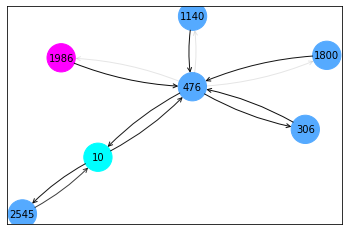

In [27]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
cora_data = cora_data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
x, edge_index = cora_data.x, cora_data.edge_index

for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    log_logits = model(x, edge_index)
    loss = F.nll_loss(log_logits[cora_data.train_mask], cora_data.y[cora_data.train_mask])
    loss.backward()
    optimizer.step()

explainer = GNNExplainer(model, epochs=200)
node_idx = 10
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=cora_data.y)
plt.show()

In [4]:
import utils

npdata = np.load(os.path.join('.','data','royalty_spouse.npz'))

train = npdata['X_train']
test = npdata['X_test']

train_exp = npdata['train_exp']
test_exp = npdata['test_exp']

full_train = np.concatenate((train,train_exp.reshape(-1,3)), axis=0)

entities = npdata['entities'].tolist()
relations = npdata['relations'].tolist()

NUM_ENTITIES = len(entities)
NUM_RELATIONS = len(relations)
NUM_FEATURES = 50

ent2idx = dict(zip(entities, range(NUM_ENTITIES)))
rel2idx = dict(zip(relations, range(NUM_RELATIONS)))

train2idx = utils.array2idx(full_train,ent2idx,rel2idx)
test2idx = utils.array2idx(test,ent2idx,rel2idx)

testexp2idx = utils.array2idx(test_exp,ent2idx,rel2idx)

# #entity_embeddings = np.load(os.path.join('.','data','transE_embeddings.npz'))['entity_embeddings']
X = np.random.randn(NUM_ENTITIES,NUM_FEATURES)

train2idx_ = np.concatenate([train2idx[:,0].reshape(-1,1),train2idx[:,2].reshape(-1,1)], axis=1)
test2idx_ = np.concatenate([test2idx[:,0].reshape(-1,1),test2idx[:,2].reshape(-1,1)], axis=1)

In [5]:
#np.concatenate([train2idx[,test2idx], axis=0).shape

all_data = np.concatenate([train2idx,test2idx], axis=0)
all_labels = np.concatenate([train2idx[:,1],test2idx[:,1]], axis=0)

train_mask = np.concatenate([np.ones(train2idx.shape[0], dtype=bool), np.zeros(test2idx.shape[0],dtype=bool)])
test_mask = np.concatenate([np.zeros(train2idx.shape[0], dtype=bool), np.ones(test2idx.shape[0],dtype=bool)])

In [16]:
# X = []
# for i,_,j in all_data:
    
#     X.append([entity_embeddings[i],entity_embeddings[j]])

# X = np.array(X)
X = torch.tensor(X)
y = torch.tensor(all_labels)

train_horizontal = np.stack([train2idx_[:,0],train2idx_[:,1]],axis=0)
test_horizontal = np.stack([test2idx_[:,0],test2idx_[:,1]],axis=0)

edge_index = torch.tensor(np.concatenate([train_horizontal, test_horizontal],axis=1), dtype=torch.long)
data = Data(x=X, y=y, edge_index=edge_index,num_classes=NUM_RELATIONS)

In [18]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(50, 16)
        self.conv2 = GCNConv(16, data.num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
x, edge_index = data.x, data.edge_index

for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    log_logits = model(x, edge_index)
    loss = F.nll_loss(log_logits[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

RuntimeError: Expected object of scalar type Double but got scalar type Float for argument #3 'mat2' in call to _th_addmm_out

In [ ]:
# X_test = torch.tensor([entity_embeddings[ent2idx[h]] for h,_,_ in test])
# y_test = torch.tensor([(rel2idx[r]) for _,r,_ in test])
# test_ents = np.array([(ent2idx[h],ent2idx[t]) for h,_,t in test]).T
# test_ents_flipped = np.stack((test_ents[1,:], test_ents[0,:]))
# test_edge_index = torch.tensor(np.concatenate((test_ents,test_ents_flipped), axis=1), dtype=torch.long)
# test_data = Data(x_test=X_test,y_test=y_test,test_edge_index=test_edge_index,num_classes=num_relations)

In [ ]:
# class Net(torch.nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.lin = Sequential(Linear(10,10))
#         self.conv1 = GCNConv(data.num_features, 16)
#         self.conv2 = GCNConv(16, data.num_classes)

#     def forward(self, x, edge_index):
#         x = F.relu(self.conv1(x, edge_index))
#         x = F.dropout(x, training=self.training)
#         x = self.conv2(x, edge_index)
#         return F.log_softmax(x, dim=1)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = Net().to(device)
# data = data.to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
# x, edge_index = data.x, data.edge_index

# for epoch in range(1, 201):
#     model.train()
#     optimizer.zero_grad()
#     log_logits = model(x, edge_index)
#     loss = F.nll_loss(log_logits, data.y)
#     loss.backward()
#     optimizer.step()

# explainer = GNNExplainer(model, epochs=200)

# x_test,test_y, test_edge_index = test_data.x_test,test_data.y_test,test_data.test_edge_index

In [ ]:
def get_explanations(i,x,y,edge_index, explainer):

    node_feat_mask, edge_mask = explainer.explain_node(i, x, edge_index)
    
    _, G = explainer.visualize_subgraph(i, edge_index, edge_mask, y=y)

    temp = []
    exp = list(G.edges)
    for tup in exp:
        sorted_tup = tuple(sorted(tup))
        temp.append(sorted_tup)

    return list(set(temp))

In [ ]:
node_feat_mask, edge_mask = explainer.explain_node(0, x, edge_index)

In [ ]:
explainer.visualize_subgraph(2278, edge_index, edge_mask, y=y)

In [ ]:
# A = np.zeros(shape=(num_entities,num_entities))

# for h,r,t in d:
    
#     h_idx = entities.index(h)
#     #r_idx = relations.index(r)
#     t_idx = entities.index(t)
    
#     A[h_idx, t_idx] = 1
    
# A = torch.tensor(A, dtype=torch.float)
#A = torch.randn(5,10)
# X = torch.randn(2708,1433)
# y = torch.randint(3, (2708,))

# X = torch.randn(10,1433)
# y = torch.randint(3, (10,))

In [ ]:
# class Net(torch.nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.lin = Sequential(Linear(10,10))
#         self.conv1 = GCNConv(data.num_features, 16)
#         self.conv2 = GCNConv(16, data.num_classes)

#     def forward(self, x, edge_index):
#         x = F.relu(self.conv1(x, edge_index))
#         x = F.dropout(x, training=self.training)
#         x = self.conv2(x, edge_index)
#         return F.log_softmax(x, dim=1)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = Net().to(device)
# data = data.to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
# x, edge_index = data.x, data.edge_index

# for epoch in range(1, 201):
#     model.train()
#     optimizer.zero_grad()
#     log_logits = model(x, edge_index)
#     loss = F.nll_loss(log_logits, data.y)
#     loss.backward()
#     optimizer.step()

# explainer = GNNExplainer(model, epochs=200)

In [ ]:
# node_idx = 3
# node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)
# ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)
# plt.show()

In [ ]:
# explanations = []

# for i in range(2):
    
#     node_feat_mask, edge_mask = explainer.explain_node(i, x, edge_index)
#     _, G = explainer.visualize_subgraph(i, edge_index, edge_mask, y=data.y)
    
#     explanations.append(list(G.edges))

In [ ]:
# unique_explanations = []
# for i in explanations:
#     temp = []
#     for tup in i:
#         sorted_tup = tuple(sorted(tup))
#         temp.append(sorted_tup)
#     unique_explanations.append(list(set(temp)))

In [ ]:
#unique_explanations